In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abtem import GridScan, PixelatedDetector, Potential, Probe, show_atoms, SMatrix, AnnularDetector, FrozenPhonons
from abtem.reconstruct import epie
from abtem.detect import FlexibleAnnularDetector
from abtem.transfer import CTF, scherzer_defocus
from ase.build import mx2
from ase.io import read
from abtem.structures import orthogonalize_cell
from abtem.measure import bandlimit

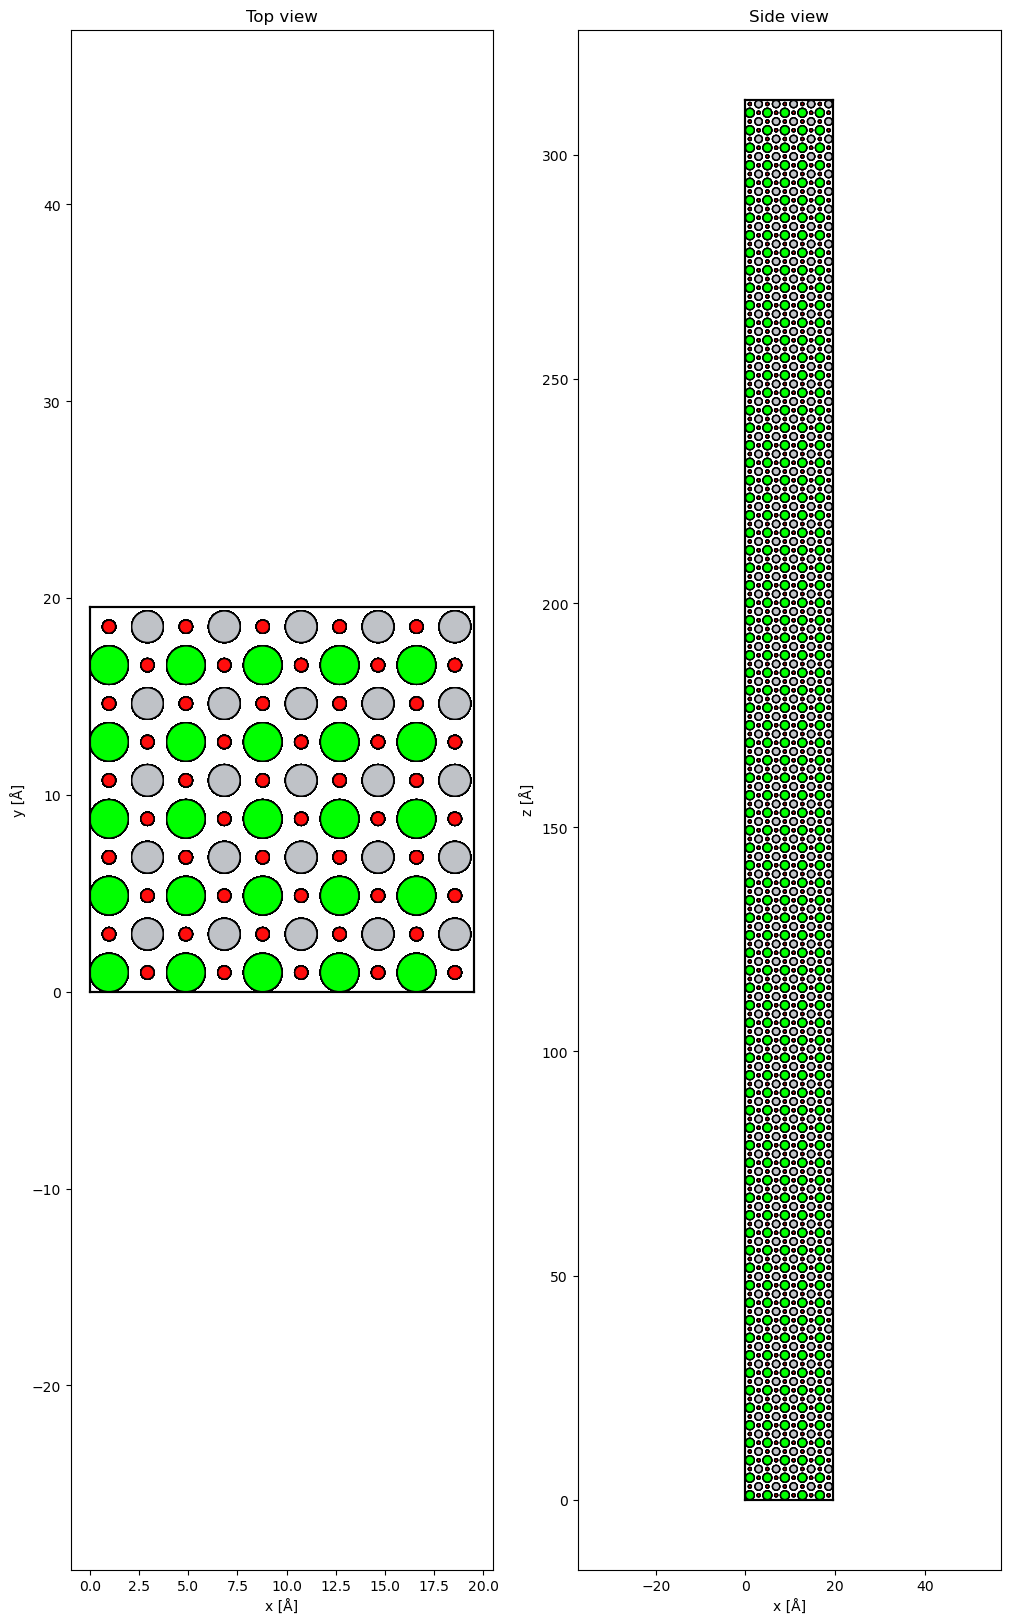

In [3]:
atoms = read('data/srtio3_100.cif')

atoms *= (5, 5, 80)
atoms.center()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')
plt.show()

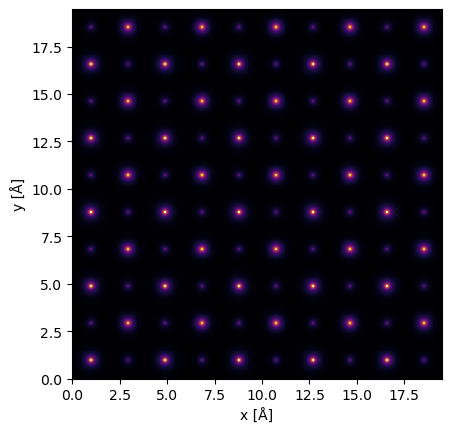

In [4]:
potential = Potential(atoms, 
                      sampling=.05,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build()
potential.project().show(cmap="inferno")
plt.show()

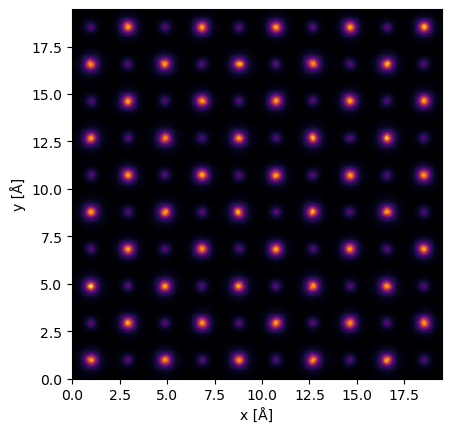

In [24]:
frozen_phonons = FrozenPhonons(atoms, 16, {"Sr":0.1, "Ti":0.1, "O":0.1}, seed=56)
tds_potential = Potential(frozen_phonons, 
                      sampling=.05,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland',
                    device="gpu").build()
tds_potential.project().show(cmap="inferno")
plt.show()

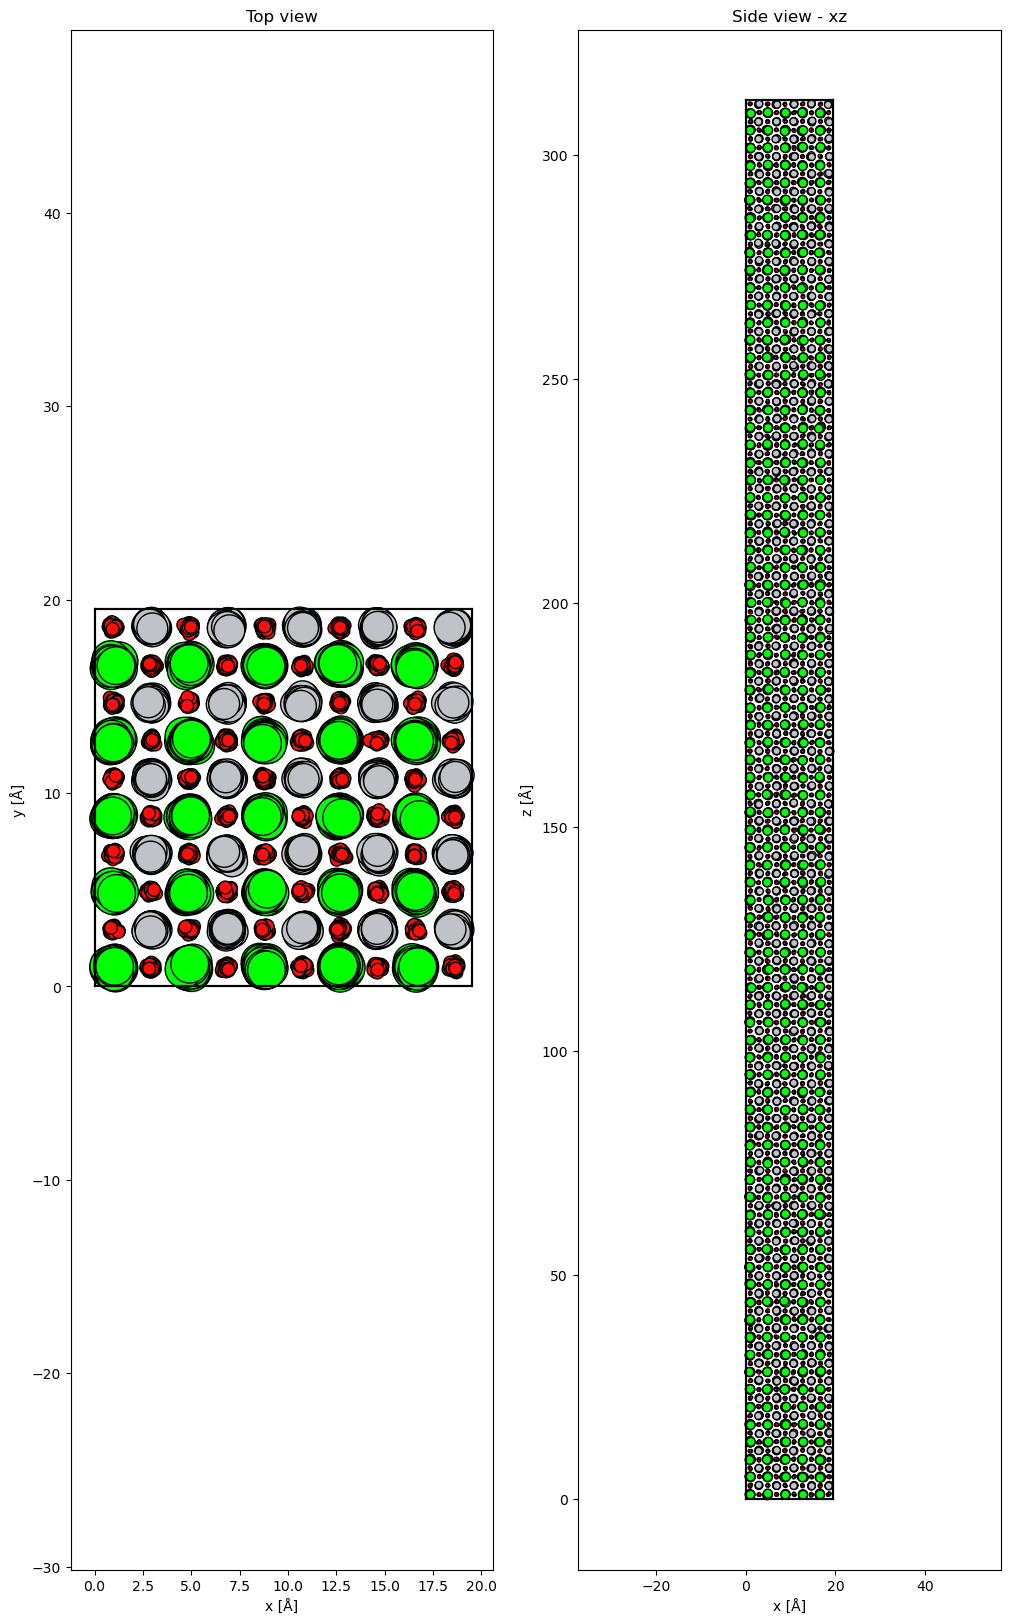

In [25]:
atoms_conf = next(iter(frozen_phonons))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20))

show_atoms(atoms_conf, ax=ax1, title='Top view')
show_atoms(atoms_conf, ax=ax2, plane='xz', title='Side view - xz')
plt.show()

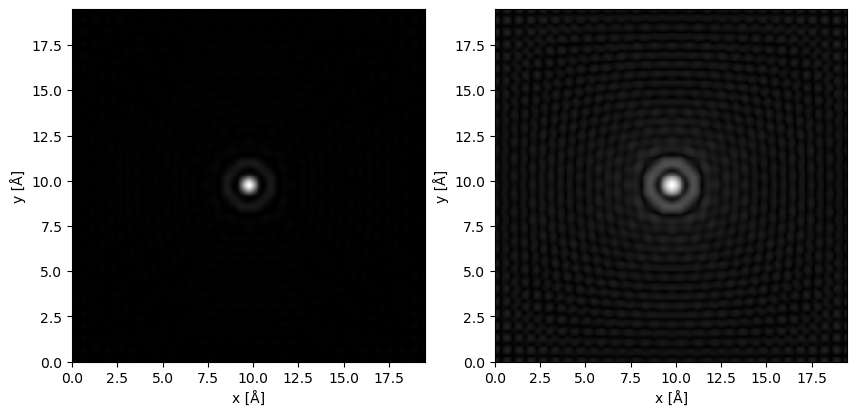

In [23]:
probe = Probe(semiangle_cutoff=30, energy=200E3, Cs=1E6, defocus=scherzer_defocus(1E6, 200E3), device="gpu")
probe.grid.match(tds_potential)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
probe.show(ax=axes[0])
probe.show(ax=axes[1], power=0.5)
plt.show()

In [20]:
print("Nyquist sampling", probe.ctf.nyquist_sampling)

Nyquist sampling 0.20899450264440392


In [26]:
gridscan = GridScan((0,0), np.array(tds_potential.extent), sampling=0.5)
detector = PixelatedDetector(max_angle=100)
measurement = probe.scan(gridscan, [detector], tds_potential)

Scan:   0%|          | 0/1521 [00:00<?, ?it/s]

In [27]:
flexible_measurement = probe.scan(gridscan, FlexibleAnnularDetector(step_size=10), tds_potential)

Scan:   0%|          | 0/1521 [00:00<?, ?it/s]

/home/jinseuk56/anaconda3/envs/ptycho/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


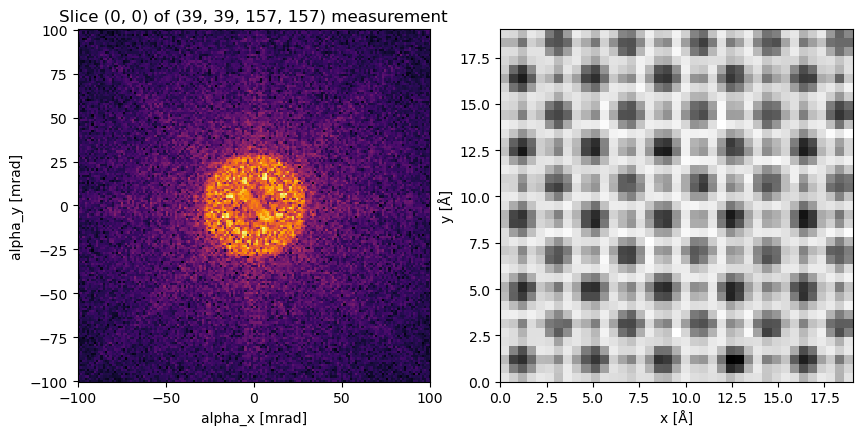

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
measurement.show(ax=axes[0], cmap="inferno", power=0.2)
flexible_measurement.integrate(10, 30).show(ax=axes[1])
plt.show()

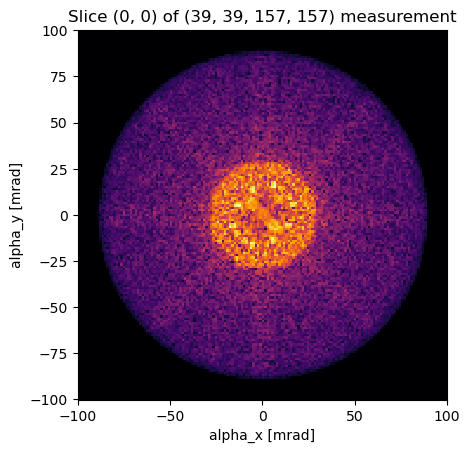

In [29]:
band_limited_measurment = bandlimit(measurement, 90)
band_limited_measurment.show(cmap="inferno", power=0.2)
plt.show()

In [30]:
probe_guess = Probe(semiangle_cutoff=30, energy=200E3)
reconstructions_full = epie(band_limited_measurment, probe_guess, maxiter=20, return_iterations=True, fix_com=True, device="gpu")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1521 [00:00<?, ?it/s]

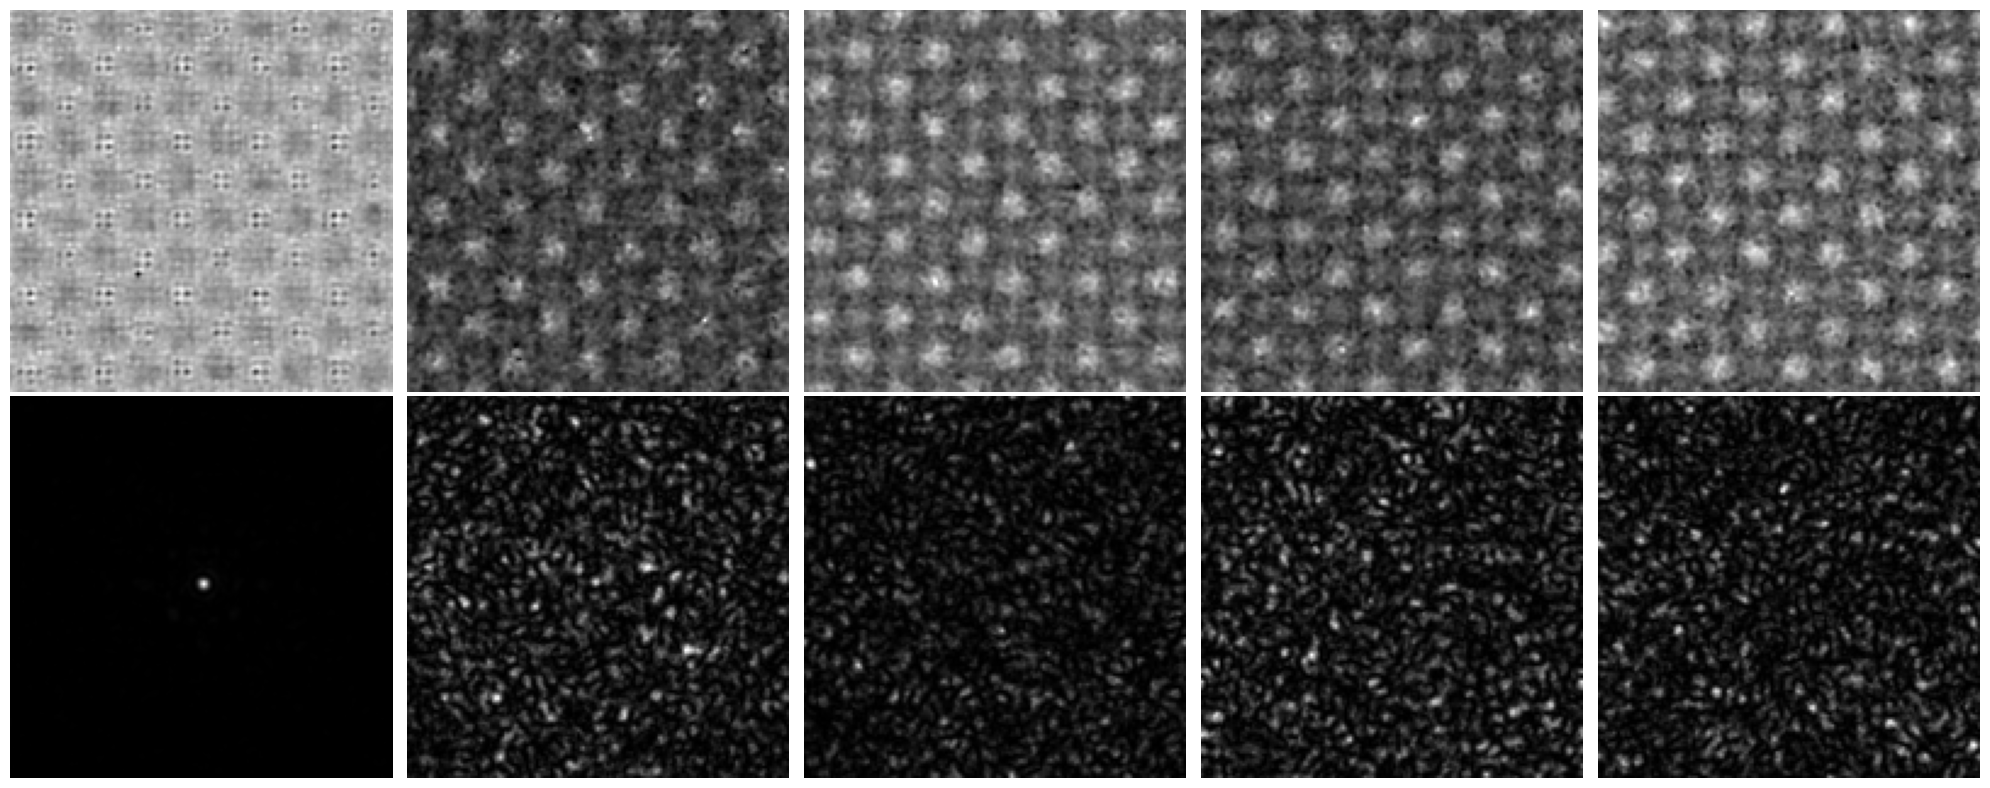

In [31]:
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_full[0]) / plot_every)), figsize=(20, 8))

for i, j in enumerate(range(0,len(reconstructions_full[0]),plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_full[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_full[1][j].array).T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
fig.tight_layout()
plt.show()

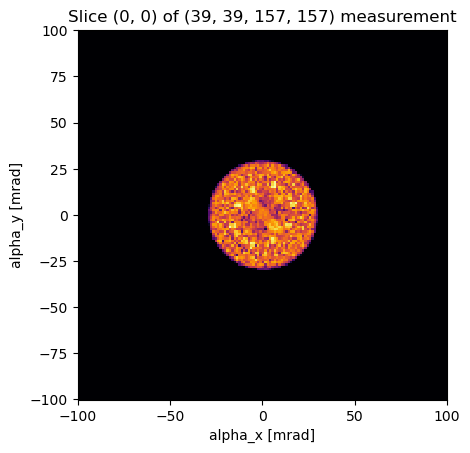

In [32]:
bright_field_measurment = bandlimit(measurement, 30)
bright_field_measurment.show(cmap="inferno", power=0.2)
plt.show()

In [33]:
probe_guess = Probe(semiangle_cutoff=30, energy=200E3)
reconstructions_bright = epie(bright_field_measurment, probe_guess, maxiter=20, return_iterations=True, fix_com=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1521 [00:00<?, ?it/s]

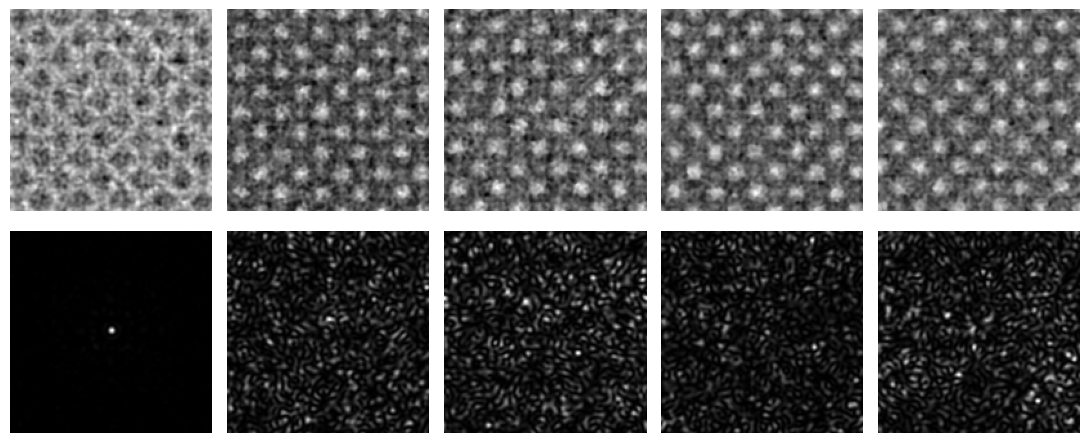

In [34]:
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_bright[0]) / plot_every)), figsize=(11,4.8))

for i, j in enumerate(range(0, len(reconstructions_bright[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_bright[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_bright[1][j].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
fig.tight_layout()
plt.show()